# Imports

In [1]:
# We will use to this to evaluate the ROUGE score of the model
!pip install evaluate &> /dev/null
!pip install rouge-score &> /dev/null
!pip install youtokentome &> /dev/null

In [2]:
import math
import pickle
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import youtokentome as yttm

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from matplotlib import pyplot as plt

import evaluate
rouge = evaluate.load('rouge')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Dataset Processing

In [4]:
NUM_INSTANCES = 1000000 # Train Dataset size limit
MAX_TITLE_LEN = 20 # Maximum input sequence length
MAX_ABSTRACT_LEN = 300 # Maximum output sequence length

In [5]:
# Create custom dataset object
class ArxivDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.data = np.load(self.data_path, allow_pickle=True)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index][1], self.data[index][0]

dataset = ArxivDataset("/content/gdrive/MyDrive/data_shortened.pickle")

In [6]:
print(type(dataset.data[0][0]))
print(f"Dataset size: {len(dataset)}")

<class 'numpy.ndarray'>
Dataset size: 1763097


In [7]:
# We we sample from this dataset by sampling from the indices
indices = list(range(len(dataset)))
test_idx = np.random.choice(indices, size = int(len(dataset) * 0.006), replace = False)
train_idx = list(set(indices) - set(test_idx))
val_idx = np.random.choice(train_idx, size = int(len(dataset) * 0.003), replace = False)
train_idx = list(set(train_idx) - set(val_idx))
train_idx = train_idx[:NUM_INSTANCES] # limit the train dataset size
train_sampler, val_sampler, test_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(val_idx), SubsetRandomSampler(test_idx)

# Create sample loaders for dataset
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 128, sampler = train_sampler, pin_memory=True)
val_loader = torch.utils.data.DataLoader(dataset, batch_size = 32, sampler = val_sampler, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset, batch_size = 32, sampler = test_sampler, pin_memory=True)

In [8]:
print(f"Train dataset size: {len(train_idx)}")
print(f"Val dataset size: {len(val_idx)}")
print(f"Test dataset size: {len(test_idx)}")

x, y = next(iter(train_loader)) # Get a batch
print(x.shape, y.shape)
x, y

Train dataset size: 1000000
Val dataset size: 5289
Test dataset size: 10578
torch.Size([128, 300]) torch.Size([128, 20])


(tensor([[   2,  527,   94,  ...,    0,    0,    0],
         [   2,  142,  625,  ...,    0,    0,    0],
         [   2,  203,  693,  ...,    0,    0,    0],
         ...,
         [   2,  142,  625,  ...,    0,    0,    0],
         [   2,  110,  203,  ...,    0,    0,    0],
         [   2,   94, 1886,  ...,    0,    0,    0]]),
 tensor([[    2, 22360,  4515,  ...,     0,     0,     0],
         [    2,  1331,  6872,  ...,     0,     0,     0],
         [    2,  1322,   223,  ...,     0,     0,     0],
         ...,
         [    2,  1471,  1129,  ...,     0,     0,     0],
         [    2, 13185,  1428,  ...,     0,     0,     0],
         [    2,  5530, 29481,  ...,     0,     0,     0]]))

In [9]:
# Load the tokenizer
bpe = yttm.BPE(model="/content/gdrive/MyDrive/tokenizer")
print(f"Vocab Size: {bpe.vocab_size()}")

Vocab Size: 30000


# Transformer Model

In [10]:
class PositionalEncoding(nn.Module):
    """
    Classic Attention-is-all-you-need positional encoding.
    Source: PyTorch docs: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


def generate_square_subsequent_mask(size):
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Source: PyTorch docs: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """
    return torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)


class Transformer(nn.Module):
    """
    Transformer model with both encoder and decoder (seq2seq).
    Prediction-time inference is done greedily (argmax of logits).
    """

    def __init__(self, vocab_size, nhead, num_layers, hidden_dim, embedding_dim, dropout, max_output_length):
        super().__init__()

        self.dim = embedding_dim
        self.max_output_length = max_output_length

        # Encoder setup
        self.enc_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(d_model=self.dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(d_model=self.dim, nhead=nhead, dim_feedforward=hidden_dim),
            num_layers=num_layers
        )

        # Decoder setup
        self.dec_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.y_mask = generate_square_subsequent_mask(self.max_output_length)
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(d_model=self.dim, nhead=nhead, dim_feedforward=hidden_dim),
            num_layers=num_layers
        )
        self.fc = nn.Linear(self.dim, vocab_size)

        # Init embedding and fc weights
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.1
        self.enc_embedding.weight.data.uniform_(-initrange, initrange)
        self.dec_embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)
      
    def forward(self, x, y) :
        """
        Compute forward pass through transformer.
        """
        encoded_x = self.encode(x)
        output = self.decode(y, encoded_x)
        return output.permute(1, 2, 0)

    def encode(self, x):
        """
        Passes x through the transformer encoder.
        """
        x = x.permute(1, 0)
        x = self.enc_embedding(x) * math.sqrt(self.dim)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        return x

    def decode(self, y, memory):
        """
        Given memory (encoder output), computes decoder output.
        """
        y = y.permute(1, 0)
        y = self.dec_embedding(y) * math.sqrt(self.dim)
        y = self.pos_encoder(y)
        y_mask = self.y_mask[:y.shape[0], :y.shape[0]].type_as(memory) # slice the mask
        output = self.transformer_decoder(y, memory, y_mask)
        output = self.fc(output)
        return output

    def predict(self, x):
        """
        Method to use at inference/test time. Predict y from x one token at a time. This method is greedy
        decoding (argmax of logits).
        """
        memory = self.encode(x)
        output_tokens = (torch.ones((x.shape[0], self.max_output_length))).type_as(x).long()
        output_tokens[:, 0] = bpe.subword_to_id("<BOS>") # Initialize with BOS index
        for o in range(1, self.max_output_length):
            y = output_tokens[:, :o] 
            output = self.decode(y, memory)
            output = torch.argmax(output, dim=-1)
            output_tokens[:, o] = output[-1:]  # Get the last output token
        return output_tokens

# Model Hyperparameter Settings
VOCAB_SIZE = bpe.vocab_size() # vocab size 
EMBEDDING_DIM = 512 # Dimension for embedding for both encoder and decoder embeddings
HIDDEN_DIM = 1024 # Number of units in feedforward network model for both encoder and decoder layers
NUM_HEADS = 8 # Number of multihead attention models
NUM_LAYERS = 4 # Number of sub-encoder/sub-decoder layers in encoder/decoder
DROPOUT = 0.2 # Dropout for positional encoding

# Create model
model = Transformer(VOCAB_SIZE, NUM_HEADS, NUM_LAYERS, HIDDEN_DIM, EMBEDDING_DIM, DROPOUT, MAX_TITLE_LEN)
model.to(DEVICE)
pass # pass to avoid outputting model summary

# Training

In [11]:
# Set up training params
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_iters = []
val_losses = []
val_iters = []
epoch = 0
n = 0

# Calculate validation loss for initial datapoint
val_loss = 0
val_total = 0
for j, (val_x, val_y) in enumerate(val_loader):
  val_x, val_y  = val_x.to(DEVICE), val_y.to(DEVICE)
  val_loss += criterion(model(val_x, val_y[:, :-1]), val_y[:, 1:]).item()
  val_total += 1
val_iters.append(n)
val_losses.append(val_loss / val_total)

# Use a infinite loop since we are checkpointing
while True:

  # Epoch pass
  for i, (x, y) in enumerate(train_loader):
    x, y  = x.to(DEVICE), y.to(DEVICE)
    logits = model(x, y[:, :-1])
    loss = criterion(logits, y[:, 1:])

    # Calculate train loss at every iteration
    train_iters.append(n)
    train_losses.append(float(loss)) 

    optimizer.zero_grad()
    loss.backward()
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5, norm_type=2.0) 
    optimizer.step()

    n += 1
    if n % 100 == 0:
      print(f"Completed Iteration {i+1}/{len(train_idx) // 128} | Total Iterations {n}") 

  # Calculate validation loss at every epoch to avoid overhead
  val_loss = 0
  val_total = 0
  for j, (val_x, val_y) in enumerate(val_loader):
    val_x, val_y  = val_x.to(DEVICE), val_y.to(DEVICE)
    val_loss += criterion(model(val_x, val_y[:, :-1]), val_y[:, 1:]).item()
    val_total += 1
  
  val_iters.append(n)
  val_losses.append(val_loss / val_total)

  # Checkpoint every epoch
  print(f"Epoch {epoch + 1} | Avg Train Loss: {train_losses[-1]:02.5f} | Avg Val Loss: {(val_loss / val_total):02.5f}")
  torch.save(model.state_dict(), f"/content/gdrive/MyDrive/checkpoints/model2-sharven-e{epoch}-i{n}.pth")

  # Save the training curve plot
  plt.title(f"Loss Learning Curve") 
  plt.plot(train_iters, train_losses, label="Train")
  plt.plot(val_iters, val_losses, label="Validation")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.savefig(f"/content/gdrive/MyDrive/checkpoints/model2-sharven-e{epoch}-i{n}.png")
  plt.close()

  epoch += 1

Completed Iteration 100/7812 | Total Iterations 100
Completed Iteration 200/7812 | Total Iterations 200
Completed Iteration 300/7812 | Total Iterations 300
Completed Iteration 400/7812 | Total Iterations 400
Completed Iteration 500/7812 | Total Iterations 500
Completed Iteration 600/7812 | Total Iterations 600
Completed Iteration 700/7812 | Total Iterations 700
Completed Iteration 800/7812 | Total Iterations 800
Completed Iteration 900/7812 | Total Iterations 900
Completed Iteration 1000/7812 | Total Iterations 1000
Completed Iteration 1100/7812 | Total Iterations 1100
Completed Iteration 1200/7812 | Total Iterations 1200
Completed Iteration 1300/7812 | Total Iterations 1300
Completed Iteration 1400/7812 | Total Iterations 1400
Completed Iteration 1500/7812 | Total Iterations 1500
Completed Iteration 1600/7812 | Total Iterations 1600
Completed Iteration 1700/7812 | Total Iterations 1700
Completed Iteration 1800/7812 | Total Iterations 1800
Completed Iteration 1900/7812 | Total Iteratio

KeyboardInterrupt: ignored

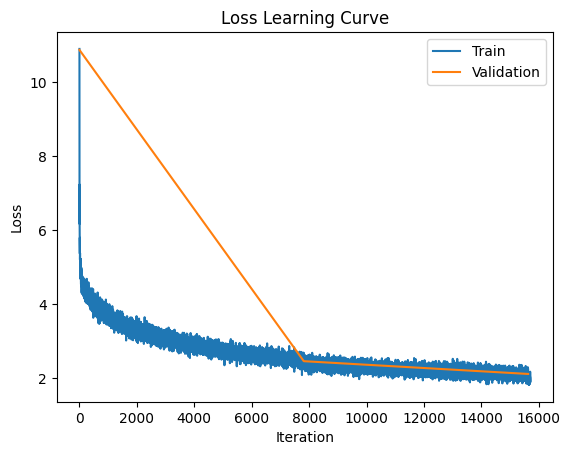

In [12]:
# Plot training curves
plt.title(f"Loss Learning Curve") 
plt.plot(train_iters, train_losses, label="Train")
plt.plot(val_iters, val_losses, label="Validation")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

# Testing (ROUGE scores)

Computer the average ROUGE scores (higher is better).

In [13]:
def get_avg_rouge_score(model, test_loader):
  """
  Compute the average ROUGE metrics given the test dataset.
  In general, ROUGE metrics compares how "similar" the prediction is compared to the expected output

  More info can be found here: https://en.wikipedia.org/wiki/ROUGE_(metric)

  Outputs a dictionary with average ROUGE-1, ROUGE-2, and ROUGE-L scores
  """
  model.eval()
  avg_scores = {"rouge1": 0, "rouge2": 0, "rougeL": 0}
  total = 0
  for i, (x, y) in enumerate(test_loader):

    x = x.to(DEVICE)
    y = y.to(DEVICE)

    logits = model(x, y[:, :-1])
    pred = model.predict(x)

    test_sentences = []
    pred_sentences = []

    for j in range(y.shape[0]):
      actual = bpe.decode(y[j, :].tolist())[0]
      actual = actual.replace("<BOS>", "").replace("<EOS>", "").replace("<PAD>", "")
      predicted = bpe.decode(pred[j, :].tolist())[0]
      predicted = predicted.replace("<BOS>", "").replace("<EOS>", "").replace("<PAD>", "")
      test_sentences.append([actual])
      pred_sentences.append(predicted)

    if i % 25 == 0:
      print(f"ROUGE Score: Completed Iteration {i+1}/{len(test_idx)//32}") 

    results = rouge.compute(predictions=pred_sentences, references=test_sentences)
    avg_scores["rougeL"] += results['rougeL']
    avg_scores["rouge2"] += results['rouge2']
    avg_scores["rouge1"] += results['rouge1']
    total += 1

  # Calculate averages
  out = {}
  out["rougeL"] = avg_scores["rougeL"] / total
  out["rouge2"] = avg_scores["rouge2"] / total
  out["rouge1"] = avg_scores["rouge1"] / total

  return out

# Test Dataset Performance

Evaluate ROUGE scores on test dataset

In [14]:
score = get_avg_rouge_score(model, test_loader)
print(f"Average ROUGE Scores {score}")

ROUGE Score: Completed Iteration 1/330
ROUGE Score: Completed Iteration 26/330
ROUGE Score: Completed Iteration 51/330
ROUGE Score: Completed Iteration 76/330
ROUGE Score: Completed Iteration 101/330
ROUGE Score: Completed Iteration 126/330
ROUGE Score: Completed Iteration 151/330
ROUGE Score: Completed Iteration 176/330
ROUGE Score: Completed Iteration 201/330
ROUGE Score: Completed Iteration 226/330
ROUGE Score: Completed Iteration 251/330
ROUGE Score: Completed Iteration 276/330
ROUGE Score: Completed Iteration 301/330
ROUGE Score: Completed Iteration 326/330
Average ROUGE Scores {'rougeL': 0.2957219944277001, 'rouge2': 0.13252754712395426, 'rouge1': 0.325192318427971}


# Inference

Predict a sequence given a sequence as input

In [31]:
src, tgt = next(iter(test_loader))
print(f"Input: {bpe.decode(src[0].tolist())}")
print(f"Expected Output: {bpe.decode(tgt[0].tolist())}")

src = src.to(DEVICE)
tgt = tgt.to(DEVICE)
model.eval()
outputs = model.predict(src[0,].unsqueeze(0))
print(f"Actual Output: {bpe.decode(outputs.tolist())}")

Input: ['<BOS> on solving a convex-concave bilinear saddle-point problem (spp), there have been many works studying the complexity results of first-order methods. these results are all about upper complexity bounds, which can determine at most how many efforts would guarantee a solution of desired accuracy. in this paper, we pursue the opposite direction by deriving lower complexity bounds of first-order methods on large-scale spps. our results apply to the methods whose iterates are in the linear span of past first-order information, as well as more general methods that produce their iterates in an arbitrary manner based on first-order information. we first work on the affinely constrained smooth convex optimization that is a special case of spp. different from gradient method on unconstrained problems, we show that first-order methods on affinely constrained problems generally cannot be accelerated from the known convergence rate $o(1/t)$ to $o(1/t^2)$, and in addition, $o(1/t)$ is o